# Concrete norm
> Regresión

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer
from functools import reduce

# https://xgboost.readthedocs.io/en/latest/python/python_api.html
import xgboost as xgb

# Cargar mi repo como paquete
from sklearn.datasets import load_boston
import sys
from os.path import abspath

try:
    from src.gaparsimony import GAparsimony
except:
    sys.path.append(abspath("C:/Users/Millan/Desktop/GAparsimony"))
    from src.gaparsimony import GAparsimony

In [2]:
df = pd.read_csv("../../data/concrete_norm.csv")
print(df.shape)
df.head()

(1030, 9)


,V1,V2,V3,V4,V5,V6,V7,V8,V9
0,1.000000,0.000000,0.0,0.321086,0.07764,0.694767,0.205720,0.074176,0.967485
1,1.000000,0.000000,0.0,0.321086,0.07764,0.738372,0.205720,0.074176,0.741996
2,0.526256,0.396494,0.0,0.848243,0.00000,0.380814,0.000000,0.739011,0.472655
3,0.526256,0.396494,0.0,0.848243,0.00000,0.380814,0.000000,1.000000,0.482372
4,0.220548,0.368392,0.0,0.560703,0.00000,0.515698,0.580783,0.986264,0.522860


V9 se corresponde con el target strength (http://rstudio-pubs-static.s3.amazonaws.com/413538_32168eafc1194c53b31c501882cbfef7.html)

In [10]:
X, y = df.iloc[:, :-1], df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

data_train = pd.DataFrame(X_train, columns=df.columns[:-1]).reset_index(drop=True)
data_test = pd.DataFrame(X_test, columns=df.columns[:-1]).reset_index(drop=True)

print(f"train: {data_train.shape} test: {data_test.shape}")

train: (824, 8) test: (206, 8)


In [11]:
data_train.head()

,V1,V2,V3,V4,V5,V6,V7,V8
0,0.129224,0.414302,0.579710,0.425719,0.465839,0.442733,0.315354,0.074176
1,0.735160,0.061213,0.659670,0.448882,0.263975,0.061047,0.391370,0.074176
2,0.395205,0.000000,0.606697,0.301118,0.307453,0.734302,0.460361,0.005495
3,0.342466,0.269894,0.379810,0.576677,0.248447,0.098837,0.569493,0.074176
4,0.152740,0.117418,0.621189,0.291534,0.335404,0.813372,0.507275,0.005495


In [12]:
data_test.head()

,V1,V2,V3,V4,V5,V6,V7,V8
0,0.374429,0.317195,0.000000,0.848243,0.000000,0.380814,0.190667,1.000000
1,0.594977,0.525876,0.000000,0.344249,0.360248,0.417733,0.405921,0.016484
2,0.657306,0.525876,0.000000,0.192492,0.683230,0.417733,0.405921,0.074176
3,0.594977,0.525876,0.000000,0.344249,0.360248,0.417733,0.405921,0.005495
4,0.098174,0.000000,0.894553,0.640575,0.248447,0.066860,0.689915,0.074176


In [13]:
def fitness_XGBoost(chromosome):
    # First two values in chromosome are 'C' & 'sigma' of 'svmRadial' method
    tuneGrid = {
                "n_estimators ": int(chromosome[0]),
                "max_depth": int(chromosome[1]),
                "min_child_weight": int(chromosome[2]),
                "reg_alpha": chromosome[3],
                "reg_lambda": chromosome[4],
                "subsample": chromosome[5],
                "colsample_bytree": chromosome[6],
                "learning_rate": 0.01,
                "random_state": 1234,
                "verbosity": 0}
    
    # Next values of chromosome are the selected features (TRUE if > 0.50)
    selec_feat = chromosome[7:]>0.50
    
    # Return -Inf if there is not selected features
    if np.sum(selec_feat)<1:
        return np.array([np.NINF, np.NINF, np.Inf])
    
    # Extract features from the original DB plus response (last column)
    data_train_model = data_train.loc[: , data_train.columns[selec_feat]] 
    data_test_model = data_test.loc[: , data_test.columns[selec_feat]] 
    
    # How to validate each individual
    # 'repeats' could be increased to obtain a more robust validation metric. Also,
    # 'number' of folds could be adjusted to improve the measure.
    train_control = RepeatedKFold(n_splits=10, n_repeats=5, random_state=123)

    # train the model
#     np.random.seed(1234)

    aux = xgb.XGBRegressor(**tuneGrid)

    model = cross_val_score(aux, data_train_model, y_train, scoring="neg_mean_squared_error", cv=train_control, n_jobs=-1)

    

    # Extract kappa statistics (the repeated k-fold CV and the kappa with the test DB)
    rmse_val = model.mean()

    model = xgb.XGBRegressor(**tuneGrid).fit(data_train_model, y_train)

    rmse_test = mean_squared_error(model.predict(data_test_model), y_test)
    # Obtain Complexity = Num_Features*1E6+Number of support vectors
    complexity = np.sum(selec_feat)*1E6 + len(model.get_booster().get_dump())
    
    # Return(validation score, testing score, model_complexity)
    return np.array([rmse_val, -rmse_test, complexity])

In [14]:
# Ranges of size and decay
min_param = np.array([10, 2, 1, 0., 0., 0.6, 0.8])
max_param = np.array([2000, 20, 20, 1., 1., 1., 1.])
names_param = ["n_estimators(nrounds)","max_depth", "min_child_weight", 
               "reg_alpha(lasso)", "reg_lambda(ridge)", "subsample",
               "colsample_bytree"]

# ga_parsimony can be executed with a different set of 'rerank_error' values
rerank_error = 0.01

In [15]:
GAparsimony_model = GAparsimony(fitness=fitness_XGBoost,
                                  min_param=min_param,
                                  max_param=max_param,
                                  names_param=names_param,
                                  nFeatures=len(df.columns[:-1]),
                                  names_features=df.columns[:-1],
                                  keep_history = True,
                                  rerank_error = rerank_error,
                                  popSize = 64,
                                  elitism = 16,
                                  maxiter = 100, early_stop=10,
                                  feat_thres=0.90, # Perc selected features in first generation
                                  feat_mut_thres=0.10, # Prob of a feature to be one in mutation
                                  parallel = True, seed_ini = 1234,
                                  verbose=GAparsimony.MONITOR)

In [16]:
GAparsimony_model.fit()

GA-PARSIMONY | iter = 0
  MeanVal = -0.0183759 |  ValBest = -0.016052  |  TstBest = -0.0143685 | ComplexBest = 6000100.0  | Time(min) = 4.5324508  

GA-PARSIMONY | iter = 1
  MeanVal = -0.0190123 |  ValBest = -0.0177363 |  TstBest = -0.0158802 | ComplexBest = 4000100.0  | Time(min) = 3.5264744  

GA-PARSIMONY | iter = 2
  MeanVal = -0.0192926 |  ValBest = -0.0201448 |  TstBest = -0.0186767 | ComplexBest = 3000100.0  | Time(min) = 3.7948918  

GA-PARSIMONY | iter = 3
  MeanVal = -0.0218308 |  ValBest = -0.0197655 |  TstBest = -0.0195436 | ComplexBest = 3000100.0  | Time(min) = 3.3781699  

GA-PARSIMONY | iter = 4
  MeanVal = -0.0217333 |  ValBest = -0.0194761 |  TstBest = -0.0184292 | ComplexBest = 3000100.0  | Time(min) = 3.5364226  

GA-PARSIMONY | iter = 5
  MeanVal = -0.0225768 |  ValBest = -0.0192103 |  TstBest = -0.0183337 | ComplexBest = 3000100.0  | Time(min) = 3.4017776  

GA-PARSIMONY | iter = 6
  MeanVal = -0.0217358 |  ValBest = -0.0191101 |  TstBest = -0.0181165 | ComplexBe

In [17]:
GAparsimony_model.summary()

+------------------------------------+
|             GA-PARSIMONY           |
+------------------------------------+

GA-PARSIMONY settings:
 Number of Parameters      = 7
 Number of Features        = 8
 Population size           = 64
 Maximum of generations    = 100
 Number of early-stop gen. = 10
 Elitism                   = 16
 Crossover probability     = 0.8
 Mutation probability      = 0.1
 Max diff(error) to ReRank = 0.01
 Perc. of 1s in first popu.= 0.9
 Prob. to be 1 in mutation = 0.1

 Search domain = 
           n_estimators(nrounds)  max_depth  min_child_weight  \
Min_param                   10.0        2.0               1.0   
Max_param                 2000.0       20.0              20.0   

           reg_alpha(lasso)  reg_lambda(ridge)  subsample  colsample_bytree  \
Min_param               0.0                0.0        0.6               0.8   
Max_param               1.0                1.0        1.0               1.0   

            V1   V2   V3   V4   V5   V6   V7   V8

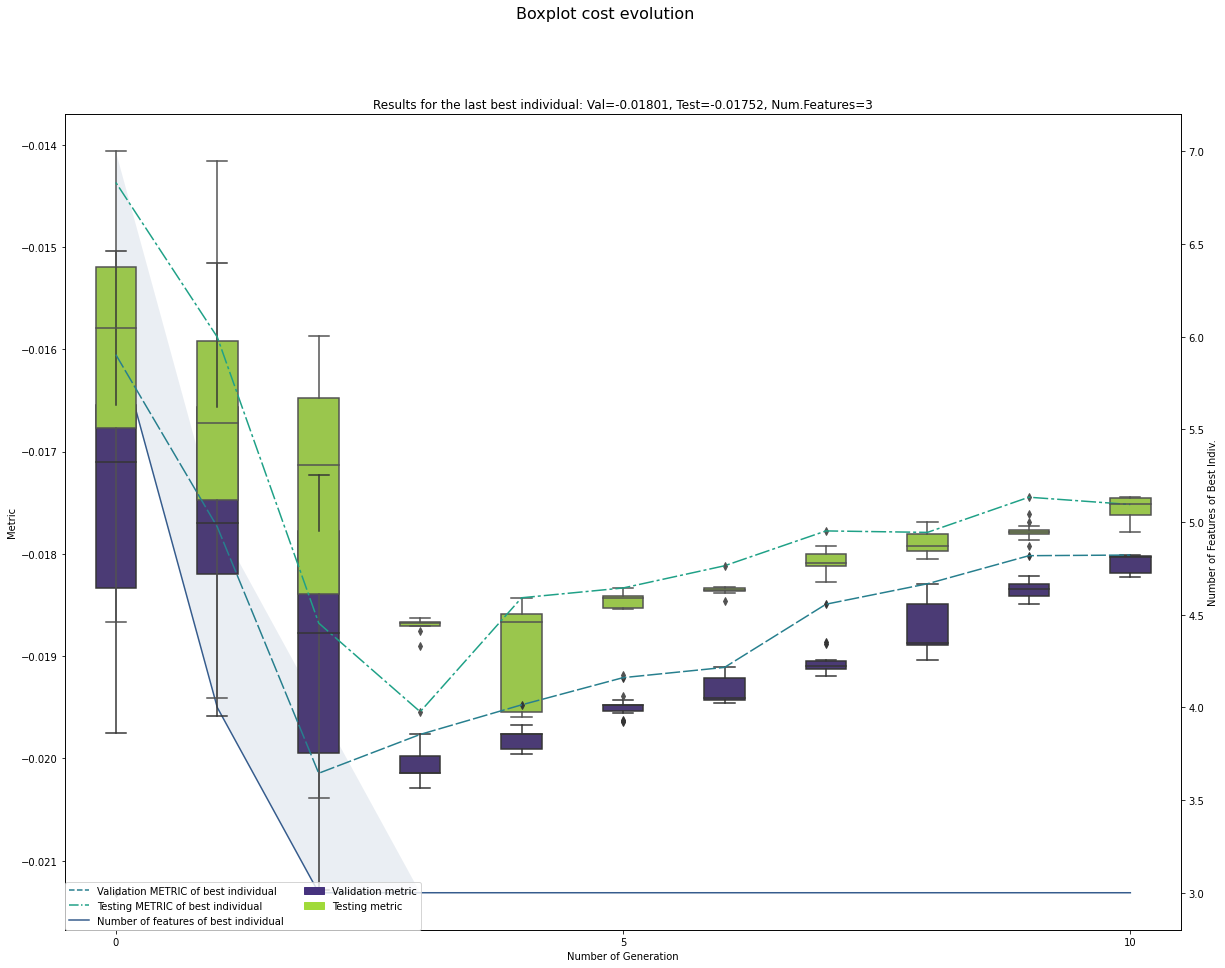

In [18]:
GAparsimony_model.plot(size_plot=(20,15))